In [2]:
# @misc{musdb18, #citation for the MUSB18 dataset
#   author       = {Rafii, Zafar and
#                   Liutkus, Antoine and
#                   Fabian-Robert St{\"o}ter and
#                   Mimilakis, Stylianos Ioannis and
#                   Bittner, Rachel},
#   title        = {The {MUSDB18} corpus for music separation},
#   month        = dec,
#   year         = 2017,
#   doi          = {10.5281/zenodo.1117372},
#   url          = {https://doi.org/10.5281/zenodo.1117372}
# }

# @inproceedings{Salamon:Scaper:WASPAA:17, #citation for the Scaper library
#   author       = {Salamon, J. and MacConnell, D. and Cartwright, M. and Li, P. and Bello, J.~P.},
#   title        = {Scaper: A Library for Soundscape Synthesis and Augmentation},
#   booktitle.   = {IEEE Workshop on Applications of Signal Processing to Audio and Acoustics (WASPAA)},
#   month        = {Oct.},
#   year         = {2017},
#   pages        = {344--348}
# }

# %matplotlib notebook
# %matplotlib widget


In [3]:
import os
import librosa
import librosa.display
import musdb
import museval
import ffmpeg
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
from IPython.display import Audio, display
from numpy import load
from tensorflow.keras import layers

In [4]:
import nussl
import IPython
# To keep things clean we'll hide all warnings
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Run this command to download X 7-second clips from MUSDB18
musdb = nussl.datasets.MUSDB18(download=True)

In [6]:
musdb_train = nussl.datasets.MUSDB18(subsets=['train'])
print(musdb_train.items)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]


In [7]:
idx = 0
item = musdb_train[idx]
item.keys()

dict_keys(['mix', 'sources', 'metadata'])

In [8]:
# for stem_label in item['sources'].keys():
#     print(stem_label)
#     audio_player = Audio(data=item['sources'][stem_label].audio_data, rate=item['sources'][stem_label].sample_rate)
#     IPython.display.display(audio_player)

In [9]:
import matplotlib
# matplotlib.use('Agg')  # or another backend, like 'TkAgg'
import matplotlib.pyplot as plt


In [10]:
from pathlib import Path

# create foreground folder
fg_folder = Path('~/.nussl/ismir2020-tutorial/foreground').expanduser()  
fg_folder.mkdir(parents=True, exist_ok=True)                             

# create background folder - we need to provide one even if we don't use it
bg_folder = Path('~/.nussl/ismir2020-tutorial/background').expanduser()
bg_folder.mkdir(parents=True, exist_ok=True)

In [11]:
# For each item (track) in the train set, iterate over its sources (stems),
# create a folder for the stem if it doesn't exist already (drums, bass, vocals, other) 
# and place the stem audio file in this folder, using the song name as the filename
for item in musdb_train:
    song_name = item['mix'].file_name
    for key, val in item['sources'].items():
        src_path = fg_folder / key 
        src_path.mkdir(exist_ok=True)
        src_path = str(src_path / song_name) + '.wav'
        val.write_audio_to_file(src_path)

In [12]:
import os
import glob

for folder in os.listdir(fg_folder):
    if folder[0] != '.':  # ignore system folders
        stem_files = os.listdir(os.path.join(fg_folder, folder))
        print(f"\n{folder}\tfolder contains {len(stem_files)} audio files:\n")
        for sf in sorted(stem_files)[:5]:
            print(f"\t\t{sf}")
        print("\t\t...")


bass	folder contains 94 audio files:

		A Classic Education - NightOwl.wav
		ANiMAL - Clinic A.wav
		ANiMAL - Easy Tiger.wav
		ANiMAL - Rockshow.wav
		Actions - Devil's Words.wav
		...

drums	folder contains 94 audio files:

		A Classic Education - NightOwl.wav
		ANiMAL - Clinic A.wav
		ANiMAL - Easy Tiger.wav
		ANiMAL - Rockshow.wav
		Actions - Devil's Words.wav
		...

other	folder contains 94 audio files:

		A Classic Education - NightOwl.wav
		ANiMAL - Clinic A.wav
		ANiMAL - Easy Tiger.wav
		ANiMAL - Rockshow.wav
		Actions - Devil's Words.wav
		...

vocals	folder contains 94 audio files:

		A Classic Education - NightOwl.wav
		ANiMAL - Clinic A.wav
		ANiMAL - Easy Tiger.wav
		ANiMAL - Rockshow.wav
		Actions - Devil's Words.wav
		...


In [13]:
import scaper

seed = 123 # integer or np.random.RandomState(<integer>)

sc = scaper.Scaper(
    duration=6.0,
    fg_path=str(fg_folder),
    bg_path=str(bg_folder),
    random_state=seed
)


In [14]:
sc.sr = 44100
sc.n_channels = 1
sc.ref_db = -20

In [15]:
import jams
import soundfile

In [16]:
labels = ['vocals', 'drums', 'bass', 'other']

for label in labels:
    sc.add_event(label=('const', label),                # set the label value explicitly using a constant
                 source_file=('choose', []),            # choose the source file randomly from all files in the folder
                 source_time=('uniform', 0, 7),         # sample the source (stem) audio starting at a time between 0-7
                 event_time=('const', 0),               # always add the stem at time 0 in the mixture
                 event_duration=('const', sc.duration), # set the stem duration to match the mixture duration
                 snr=('uniform', -5, 5),                # choose an SNR for the stem uniformly between -5 and 5 dB
                 pitch_shift=('uniform', -2, 2),        # apply a random pitch shift between -2 and 2 semitones
                 time_stretch=('uniform', 0.8, 1.2))    # apply a random time stretch between 0.8 (faster) and 1.2 (slower)

In [17]:
def generate_and_play(sc):

    mixture_audio, mixture_jam, annotation_list, stem_audio_list = sc.generate(fix_clipping=True)

    print("Mixture:")
    display(Audio(data=mixture_audio.T, rate=sc.sr))

    # extract the annotation data from the JAMS object
    ann = mixture_jam.annotations.search(namespace='scaper')[0]
    
    # iterate over the annotation and corresponding stem audio data
    for obs, stem_audio in zip(ann.data, stem_audio_list):
        print(f"Instrument: {obs.value['label']} at SNR: {obs.value['snr']:.2f}")
        display(Audio(data=stem_audio.T, rate=sc.sr))

In [18]:
# Create a template of probabilistic event parameters
template_event_parameters = {
    'label': ('const', 'vocals'),
    'source_file': ('choose', []),
    'source_time': ('uniform', 0, 7),
    'event_time': ('const', 0),
    'event_duration': ('const', 6.0),
    'snr': ('uniform', -5, 5),
    'pitch_shift': ('uniform', -2, 2),
    'time_stretch': ('uniform', 0.8, 1.2)
}


def incoherent(fg_folder, bg_folder, event_template, seed):
    """
    This function takes the paths to the MUSDB18 source materials, an event template, 
    and a random seed, and returns an INCOHERENT mixture (audio + annotations). 
    
    Stems in INCOHERENT mixtures may come from different songs and are not temporally
    aligned.
    
    Parameters
    ----------
    fg_folder : str
        Path to the foreground source material for MUSDB18
    bg_folder : str
        Path to the background material for MUSDB18 (empty folder)
    event_template: dict
        Dictionary containing a template of probabilistic event parameters
    seed : int or np.random.RandomState()
        Seed for setting the Scaper object's random state. Different seeds will 
        generate different mixtures for the same source material and event template.
        
    Returns
    -------
    mixture_audio : np.ndarray
        Audio signal for the mixture
    mixture_jams : np.ndarray
        JAMS annotation for the mixture
    annotation_list : list
        Simple annotation in list format
    stem_audio_list : list
        List containing the audio signals of the stems that comprise the mixture
    """
    
    # Create scaper object and seed random state
    sc = scaper.Scaper(
        duration=6.0,
        fg_path=str(fg_folder),
        bg_path=str(bg_folder),
        random_state=seed
    )
    
    # Set sample rate, reference dB, and channels (mono)
    sc.sr = 44100
    sc.ref_db = -20
    sc.n_channels = 1
    
    # Copy the template so we can change it
    event_parameters = event_template.copy()
    
    # Iterate over stem types and add INCOHERENT events
    labels = ['vocals', 'drums', 'bass', 'other']
    for label in labels:
        event_parameters['label'] = ('const', label)
        sc.add_event(**event_parameters)
    
    # Return the generated mixture audio + annotations 
    # while ensuring we prevent audio clipping
    return sc.generate(fix_clipping=True)


def coherent(fg_folder, bg_folder, event_template, seed):
    """
    This function takes the paths to the MUSDB18 source materials and a random seed,
    and returns an COHERENT mixture (audio + annotations).
    
    Stems in COHERENT mixtures come from the same song and are temporally aligned.
    
    Parameters
    ----------
    fg_folder : str
        Path to the foreground source material for MUSDB18
    bg_folder : str
        Path to the background material for MUSDB18 (empty folder)
    event_template: dict
        Dictionary containing a template of probabilistic event parameters
    seed : int or np.random.RandomState()
        Seed for setting the Scaper object's random state. Different seeds will 
        generate different mixtures for the same source material and event template.
        
    Returns
    -------
    mixture_audio : np.ndarray
        Audio signal for the mixture
    mixture_jams : np.ndarray
        JAMS annotation for the mixture
    annotation_list : list
        Simple annotation in list format
    stem_audio_list : list
        List containing the audio signals of the stems that comprise the mixture
    """
        
    # Create scaper object and seed random state
    sc = scaper.Scaper(
        duration=6.0,
        fg_path=str(fg_folder),
        bg_path=str(bg_folder),
        random_state=seed
    )
    
    # Set sample rate, reference dB, and channels (mono)
    sc.sr = 44100
    sc.ref_db = -20
    sc.n_channels = 1
    
    # Copy the template so we can change it
    event_parameters = event_template.copy()    
    
    # Instatiate the template once to randomly choose a song,   
    # a start time for the sources, a pitch shift and a time    
    # stretch. These values must remain COHERENT across all stems
    sc.add_event(**event_parameters)
    event = sc._instantiate_event(sc.fg_spec[0])
    
    # Reset the Scaper object's the event specification
    sc.reset_fg_event_spec()
    
    # Replace the distributions for source time, pitch shift and 
    # time stretch with the constant values we just sampled, to  
    # ensure our added events (stems) are coherent.              
    event_parameters['source_time'] = ('const', event.source_time)
    event_parameters['pitch_shift'] = ('const', event.pitch_shift)
    event_parameters['time_stretch'] = ('const', event.time_stretch)

    # Iterate over the four stems (vocals, drums, bass, other) and 
    # add COHERENT events.                                         
    labels = ['vocals', 'drums', 'bass', 'other']
    for label in labels:
        
        # Set the label to the stem we are adding
        event_parameters['label'] = ('const', label)
        
        # To ensure coherent source files (all from the same song), we leverage
        # the fact that all the stems from the same song have the same filename.
        # All we have to do is replace the stem file's parent folder name from "vocals" 
        # to the label we are adding in this iteration of the loop, which will give the 
        # correct path to the stem source file for this current label.
        coherent_source_file = event.source_file.replace('vocals', label)
        event_parameters['source_file'] = ('const', coherent_source_file)
        # Add the event using the modified, COHERENT, event parameters
        sc.add_event(**event_parameters)
    
    # Generate and return the mixture audio, stem audio, and annotations
    return sc.generate(fix_clipping=True)

In [19]:
# # First double check our paths and template are correct:
# print(fg_folder)
# print(bg_folder)
# print("")
# print(template_event_parameters)

In [20]:
import numpy as np

def generate_mixture(dataset, fg_folder, bg_folder, event_template, seed):
    
    # hide warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        
        # flip a coint to choose coherent or incoherent mixing
        random_state = np.random.RandomState(seed)
        
        # generate mixture
        if random_state.rand() > .5:
            data = coherent(fg_folder, bg_folder, event_template, seed)
        else:
            data = incoherent(fg_folder, bg_folder, event_template, seed)
            
    # unpack the data
    mixture_audio, mixture_jam, annotation_list, stem_audio_list = data
    
    # convert mixture to nussl format
    mix = dataset._load_audio_from_array(
        audio_data=mixture_audio, sample_rate=dataset.sample_rate
    )
    
    # convert stems to nussl format
    sources = {}
    ann = mixture_jam.annotations.search(namespace='scaper')[0]
    for obs, stem_audio in zip(ann.data, stem_audio_list):
        key = obs.value['label']
        sources[key] = dataset._load_audio_from_array(
            audio_data=stem_audio, sample_rate=dataset.sample_rate
        )
    
    # store the mixture, stems and JAMS annotation in the format expected by nussl
    output = {
        'mix': mix,
        'sources': sources,
        'metadata': mixture_jam
    }
    return output

In [21]:
# Convenience class so we don't need to enter the fg_folder, bg_folder, and template each time
class MixClosure:
    
    def __init__(self, fg_folder, bg_folder, event_template):
        self.fg_folder = fg_folder
        self.bg_folder = bg_folder
        self.event_template = event_template
        
    def __call__(self, dataset, seed):
        return generate_mixture(dataset, self.fg_folder, self.bg_folder, self.event_template, seed)
    
# Initialize our mixing function with our specific source material and event template
mix_func = MixClosure(fg_folder, bg_folder, template_event_parameters)

# Create a nussle OnTheFly data generator
on_the_fly = nussl.datasets.OnTheFly(
    num_mixtures=1000,
    mix_closure=mix_func
)

In [22]:
stft_params = nussl.STFTParams(window_length=512, hop_length=128, window_type='sqrt_hann')
fg_path = "~/.nussl/tutorial/train"
# train_data = musdb_train.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=1000, coherent_prob=1.0)

In [23]:
musdb_test = nussl.datasets.MUSDB18(subsets=['test'])

In [24]:
fg_path = "~/.nussl/tutorial/test"
# test_data = musdb_test.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=100)

In [25]:
from nussl.datasets import transforms as nussl_tfm

item = musdb_train[0]
sum_sources = nussl_tfm.SumSources([['bass', 'drums', 'other']])
item = sum_sources(item)
print(item)


{'mix': <nussl.core.audio_signal.AudioSignal object at 0x0000023277A384C0>, 'sources': {'vocals': <nussl.core.audio_signal.AudioSignal object at 0x0000023277A905E0>, 'bass+drums+other': <nussl.core.audio_signal.AudioSignal object at 0x0000023277A90BB0>}, 'metadata': {'labels': ['bass', 'drums', 'other', 'vocals', 'bass+drums+other']}}


In [26]:
msa = nussl_tfm.MagnitudeSpectrumApproximation()
item = msa(item)

print(item.keys())

dict_keys(['mix', 'sources', 'metadata', 'mix_magnitude', 'ideal_binary_mask', 'source_magnitudes'])


In [27]:
print(item['source_magnitudes'].shape, item['mix_magnitude'].shape, item['ideal_binary_mask'].shape)

(1025, 587, 2, 2) (1025, 587, 2) (1025, 587, 2, 2)


In [28]:
# import matplotlib.pyplot as plt
# plt.imshow(item['source_magnitudes'][..., 1][..., 0], aspect='auto', origin='lower')
# plt.title('Magnitude spectrogram of vocals source')
# plt.xlabel('Time frame')
# plt.ylabel('Frequency bin')
# plt.show()

In [29]:
index_sources = nussl_tfm.IndexSources('source_magnitudes', 1)
item = index_sources(item)

In [30]:
# import matplotlib.pyplot as plt
# plt.imshow(item['source_magnitudes'][..., 0, 0], aspect='auto', origin='lower')
# plt.title('Magnitude spectrogram of vocals source')
# plt.xlabel('Time frame')
# plt.ylabel('Frequency bin')
# plt.show()

# print(item['source_magnitudes'].shape, item['mix_magnitude'].shape, item['ideal_binary_mask'].shape)

In [31]:
to_separation_model = nussl_tfm.ToSeparationModel()
item = to_separation_model(item)

In [32]:
print(item.keys())
for key in item:
    print(key, type(item[key]), item[key].shape)

dict_keys(['mix_magnitude', 'ideal_binary_mask', 'source_magnitudes'])
mix_magnitude <class 'torch.Tensor'> torch.Size([587, 1025, 2])
ideal_binary_mask <class 'torch.Tensor'> torch.Size([587, 1025, 2, 2])
source_magnitudes <class 'torch.Tensor'> torch.Size([587, 1025, 2, 1])


In [33]:
tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])

item = musdb_train[0]
print("Before transforms")
for key in item:
    print(key, type(item[key]))
print("\nAfter transforms")
item = tfm(item)
for key in item:
    print(key, type(item[key]))

Before transforms
mix <class 'nussl.core.audio_signal.AudioSignal'>
sources <class 'dict'>
metadata <class 'dict'>

After transforms
mix_magnitude <class 'torch.Tensor'>
ideal_binary_mask <class 'torch.Tensor'>
source_magnitudes <class 'torch.Tensor'>


In [34]:
def audio_to_spectrogram(audio, sr=44100, n_fft=2048, hop_length=1024, window='hann', center=True):
    spectrogram = librosa.stft(y=audio[:, 0], n_fft=n_fft, hop_length=hop_length, window=window, center=center)
    return librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)


In [35]:
import numpy as np

def generate_mixture(dataset, fg_folder, bg_folder, event_template, seed):
    
    # hide warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        
        # flip a coint to choose coherent or incoherent mixing
        random_state = np.random.RandomState(seed)
        
        # generate mixture
        if random_state.rand() > .5:
            data = coherent(fg_folder, bg_folder, event_template, seed)
        else:
            data = incoherent(fg_folder, bg_folder, event_template, seed)
            
    # unpack the data
    mixture_audio, mixture_jam, annotation_list, stem_audio_list = data
    
    # convert mixture to nussl format
    mix = dataset._load_audio_from_array(
        audio_data=mixture_audio, sample_rate=dataset.sample_rate
    )
    
    # convert stems to nussl format
    sources = {}
    ann = mixture_jam.annotations.search(namespace='scaper')[0]
    for obs, stem_audio in zip(ann.data, stem_audio_list):
        key = obs.value['label']
        sources[key] = dataset._load_audio_from_array(
            audio_data=stem_audio, sample_rate=dataset.sample_rate
        )
    
    # store the mixture, stems and JAMS annotation in the format expected by nussl
    output = {
        'mix': mix,
        'sources': sources,
        'metadata': mixture_jam
    }
    return output

In [36]:
from pathlib import Path

# create foreground folder
fg_folder = Path('~/.nussl/ismir2020-tutorial/foreground').expanduser()  
fg_folder.mkdir(parents=True, exist_ok=True)                             

# create background folder - we need to provide one even if we don't use it
bg_folder = Path('~/.nussl/ismir2020-tutorial/background').expanduser()
bg_folder.mkdir(parents=True, exist_ok=True)

# Convenience class so we don't need to enter the fg_folder, bg_folder, and template each time
class MixClosure:
    
    def __init__(self, fg_folder, bg_folder, event_template):
        self.fg_folder = fg_folder
        self.bg_folder = bg_folder
        self.event_template = event_template
        
    def __call__(self, dataset, seed):
        return generate_mixture(dataset, self.fg_folder, self.bg_folder, self.event_template, seed)
    
# Initialize our mixing function with our specific source material and event template
mix_func = MixClosure(fg_folder, bg_folder, template_event_parameters)

# Create a nussle OnTheFly data generator
on_the_fly = nussl.datasets.OnTheFly(
    num_mixtures=1000,
    mix_closure=mix_func
)

In [37]:
import numpy as np
import librosa

def generate_spectrograms(mixture_audio, stem_audio_list):
    mixture_spectrogram = np.abs(librosa.stft(mixture_audio.squeeze())).astype(np.float32)
    stem_spectrograms = [np.abs(librosa.stft(stem_audio.squeeze())).astype(np.float32) for stem_audio in stem_audio_list]
    return mixture_spectrogram, stem_spectrograms


In [38]:
import numpy as np
from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, fg_folder, bg_folder, event_template, batch_size=1, num_batches=100, shuffle=True, seed=None):
        self.fg_folder = fg_folder
        self.bg_folder = bg_folder
        self.event_template = event_template
        self.batch_size = batch_size
        self.num_batches = num_batches
        self.shuffle = shuffle
        self.seed = seed if seed is not None else np.random.randint(1000000)
        self.on_epoch_end()

    def __len__(self):
        return self.num_batches

    def on_epoch_end(self):
        if self.shuffle:
            self.seed = np.random.randint(1000000)

    def __getitem__(self, idx):
        np.random.seed(self.seed + idx)
        batch_mixtures = []
        batch_stems = []

        for _ in range(self.batch_size):
            mixture_audio, _, _, stem_audio_list = incoherent(
                self.fg_folder,
                self.bg_folder,
                self.event_template,
                self.seed)
            
            mixture_spectrogram, stem_spectrograms = generate_spectrograms(mixture_audio, stem_audio_list)

            batch_mixtures.append(mixture_spectrogram)
            batch_stems.append(np.stack(stem_spectrograms))

        batch_mixtures = np.array(batch_mixtures)
        batch_stems = np.array(batch_stems)

        return batch_mixtures, batch_stems


In [39]:
from pathlib import Path

# create foreground folder
fg_folder = Path('~/.nussl/ismir2020-tutorial/foreground').expanduser()  
fg_folder.mkdir(parents=True, exist_ok=True)                             

# create background folder - we need to provide one even if we don't use it
bg_folder = Path('~/.nussl/ismir2020-tutorial/background').expanduser()
bg_folder.mkdir(parents=True, exist_ok=True)

event_template = {
    'label': ('const', 'vocals'),
    'source_file': ('choose', []),
    'source_time': ('uniform', 0, 7),
    'event_time': ('const', 0),
    'event_duration': ('const', 6.0),
    'snr': ('uniform', -5, 5),
    'pitch_shift': ('uniform', -2, 2),
    'time_stretch': ('uniform', 0.8, 1.2)
}

train_generator = CustomDataGenerator(fg_folder, bg_folder, event_template, batch_size=1, num_batches=100, shuffle=True, seed=42)
val_generator = CustomDataGenerator(fg_folder, bg_folder, event_template, batch_size=1, num_batches=20, shuffle=True, seed=84)


In [40]:
# import numpy as np
# import librosa
# import tensorflow as tf
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate, ZeroPadding1D, Reshape
# from tensorflow.keras.models import Model

# def unet_model(input_shape, num_sources):
#     inputs = Input(input_shape)
    
#     # New Conv1D layer to adapt input shape
#     adapt = Conv1D(16, 3, activation='relu', padding='same')(inputs)
#     adapt = Reshape((-1, 16))(adapt)

#     # Encoder
#     conv1 = Conv1D(16, 3, activation='relu', padding='same')(adapt)
#     pool1 = MaxPooling1D(pool_size=2)(conv1)

#     conv2 = Conv1D(32, 3, activation='relu', padding='same')(pool1)
#     pool2 = MaxPooling1D(pool_size=2)(conv2)

#     # Bottleneck
#     conv3 = Conv1D(64, 3, activation='relu', padding='same')(pool2)

#     # Decoder
#     up4 = concatenate([UpSampling1D(size=2)(conv3), conv2], axis=-1)
#     conv4 = Conv1D(32, 3, activation='relu', padding='same')(up4)

#     up5 = UpSampling1D(size=2)(conv4)
#     up5 = ZeroPadding1D((1, 0))(up5)  # Add padding to match the dimensions
#     up5 = concatenate([up5, conv1], axis=-1)
    
#     conv5 = Conv1D(16, 3, activation='relu', padding='same')(up5)

#     # Output layer
#     outputs = Conv1D(num_sources, 1, activation='linear')(conv5)
#     outputs = Reshape((-1, num_sources))(outputs)

#     return Model(inputs=[inputs], outputs=[outputs])


# # Get a sample from the train_generator
# train_iterator = iter(train_generator)
# sample_input, sample_output = next(train_iterator)

# # Get the input shape and number of sources
# input_shape = sample_input.shape[1:3]
# num_sources = sample_output.shape[-1]

# # Create the U-Net model
# model = unet_model(input_shape, num_sources)
# model.summary()




In [41]:
# import numpy as np
# import librosa
# import tensorflow as tf
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate, ZeroPadding1D, Reshape
# from tensorflow.keras.models import Model


# def unet_model(input_shape, num_sources):
#     inputs = Input(input_shape)

#     # Encoder
#     conv1 = Conv1D(16, 3, activation='relu', padding='same')(inputs)
#     pool1 = MaxPooling1D(pool_size=2)(conv1)

#     conv2 = Conv1D(32, 3, activation='relu', padding='same')(pool1)
#     pool2 = MaxPooling1D(pool_size=2)(conv2)

#     # Bottleneck
#     conv3 = Conv1D(64, 3, activation='relu', padding='same')(pool2)

#     # Decoder
#     up4 = concatenate([UpSampling1D(size=2)(conv3), conv2], axis=-1)
#     conv4 = Conv1D(32, 3, activation='relu', padding='same')(up4)

#     up5 = UpSampling1D(size=2)(conv4)
#     up5 = concatenate([up5, conv1], axis=-1)
    
#     conv5 = Conv1D(16, 3, activation='relu', padding='same')(up5)

#     # Output layer
#     outputs = Conv1D(4, 1, activation='linear', padding='same')(conv5)
#     outputs = Reshape((4, -1, 1))(outputs)

#     return Model(inputs=[inputs], outputs=[outputs])


# input_shape = (264600, 1)
# # Output layer

# # Create the U-Net model
# model = unet_model(input_shape, num_sources)
# model.summary()



In [42]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# def preprocess_audio(audio):

#     scaler = MinMaxScaler()
#     audio = audio.reshape(audio.shape[0], -1)
#     preprocessed_audio = scaler.fit_transform(audio).reshape(audio.shape)

#     return preprocessed_audio

# def dataset_generator_test(fg_folder, bg_folder, template_event_parameters, seed, batch_size=1):
#     while True:
#         X_batch = []
#         y_batch = []
        
#         for _ in range(batch_size):
#             mixture_audio, mixture_jam, annotation_list, stem_audio_list = incoherent(fg_folder, bg_folder, template_event_parameters, seed)
#             x = mixture_audio[:, np.newaxis]
#             y = np.stack([stem_audio[:, np.newaxis] for stem_audio in stem_audio_list], axis=0)

#             X = preprocess_audio(mixture_audio)
#             y = np.array([preprocess_audio(stem_audio) for stem_audio in stem_audio_list])
            
#             X_batch.append(X)
#             y_batch.append(y)
        
#         X_batch = np.stack(X_batch, axis=0)
#         y_batch = np.stack(y_batch, axis=0)
        
#         yield X_batch, y_batch

# num_mixtures = np.random.randint(1, 2)

# # Loop through the generator to retrieve X and y values
# for i in range(num_mixtures):
#     generator = dataset_generator_test(fg_folder, bg_folder, template_event_parameters, seed + i)
#     for data in generator:
#         X, y = data[:2]
#         # print(f"Mixture {i + 1}:")
#         print("X =", X.shape)
#         print("y =", y.shape)
#         break



In [43]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# def preprocess_audio(audio):
#     scaler = MinMaxScaler()
#     audio = audio.reshape(audio.shape[0], -1)
#     preprocessed_audio = scaler.fit_transform(audio).reshape(audio.shape)

#     return preprocessed_audio

# def dataset_generator(fg_folder, bg_folder, template_event_parameters, seed, batch_size=1):
#     while True:
#         X_batch = []
#         y_batch_fg = []
#         y_batch_bg = []
        
#         for _ in range(batch_size):
#             mixture_audio, mixture_jam, annotation_list, stem_audio_list = incoherent(fg_folder, bg_folder, template_event_parameters, seed)
#             x = mixture_audio[:, np.newaxis]
#             y = np.stack([stem_audio[:, np.newaxis] for stem_audio in stem_audio_list], axis=0)

#             X = preprocess_audio(mixture_audio)
#             y = np.array([preprocess_audio(stem_audio) for stem_audio in stem_audio_list])
            
#             X_batch.append(X)
#             y_batch_fg.append(y[0])  # Assuming foreground is the first stem
#             y_batch_bg.append(y[1])  # Assuming background is the second stem
        
#         X_batch = np.stack(X_batch, axis=0)
#         y_batch_fg = np.stack(y_batch_fg, axis=0)
#         y_batch_bg = np.stack(y_batch_bg, axis=0)
        
#         yield X_batch, [y_batch_fg, y_batch_bg]

# num_mixtures = np.random.randint(1, 2)

# # Loop through the generator to retrieve X and y values
# for i in range(num_mixtures):
#     generator = dataset_generator(fg_folder, bg_folder, template_event_parameters, seed + i)
#     for data in generator:
#         X, y = data
#         print("X =", X.shape)
#         print("y_fg =", y[0].shape)
#         print("y_bg =", y[1].shape)
#         break


In [44]:
# import os
# import numpy as np
# import librosa
# import scaper
# from sklearn.preprocessing import MinMaxScaler
# from IPython.display import Audio
# from pathlib import Path
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error

# template_event_parameters = {
#     'label': ('const', 'vocals'),
#     'source_file': ('choose', []),
#     'source_time': ('uniform', 0, 7),
#     'event_time': ('const', 0),
#     'event_duration': ('const', 6.0),
#     'snr': ('uniform', -5, 5),
#     'pitch_shift': ('uniform', -2, 2),
#     'time_stretch': ('uniform', 0.8, 1.2)
# }

# # create foreground folder
# fg_folder = Path('~/.nussl/ismir2020-tutorial/foreground').expanduser()  
# fg_folder.mkdir(parents=True, exist_ok=True)                             

# # create background folder - we need to provide one even if we don't use it
# bg_folder = Path('~/.nussl/ismir2020-tutorial/background').expanduser()
# bg_folder.mkdir(parents=True, exist_ok=True)

# def spectrogram_to_audio(spectrogram):

#     # Use the Griffin-Lim algorithm to reconstruct the audio waveform
#     audio = librosa.griffinlim(spectrogram)
    
#     return audio

# # Your provided functions
# def generate_spectrograms(mixture_audio, stem_audio_list):
#     mixture_spectrogram = np.abs(librosa.stft(mixture_audio.squeeze())).astype(np.float32)
#     stem_spectrograms = [np.abs(librosa.stft(stem_audio.squeeze())).astype(np.float32) for stem_audio in stem_audio_list]
#     return mixture_spectrogram, stem_spectrograms

# def preprocess_audio(audio):
#     scaler = MinMaxScaler()
#     audio = audio.reshape(audio.shape[0], -1)
#     preprocessed_audio = scaler.fit_transform(audio).reshape(audio.shape)
#     return preprocessed_audio, scaler

# def postprocess_audio(preprocessed_audio, scaler):
#     preprocessed_audio = preprocessed_audio.reshape(preprocessed_audio.shape[0], -1)
#     audio = scaler.inverse_transform(preprocessed_audio).reshape(preprocessed_audio.shape)
#     return audio

# def dataset_generator_tester(fg_folder, bg_folder, template_event_parameters, seed, batch_size=1):
#     while True:
#         X_batch = []
#         y_batch = []
        
#         for _ in range(batch_size):
#             mixture_audio, mixture_jam, annotation_list, stem_audio_list = incoherent(fg_folder, bg_folder, template_event_parameters, seed)
#             mixture_spectrogram, stem_spectrograms = generate_spectrograms(mixture_audio, stem_audio_list)

#             X, scaler = preprocess_audio(mixture_spectrogram)
#             y = [preprocess_audio(stem_spectrogram)[0] for stem_spectrogram in stem_spectrograms]
            
#             X_batch.append(X)
#             y_batch.append(y)
        
#         X_batch = np.stack(X_batch, axis=0)
#         y_batch = np.stack(y_batch, axis=0)
        
#         yield X_batch, y_batch, mixture_audio, stem_audio_list

# seed = 42
# mse_losses = []
# num_mixtures = np.random.randint(1, 2)

# # Loop through the generator to retrieve X and y values
# for i in range(num_mixtures):
#     generator = dataset_generator_tester(fg_folder, bg_folder, template_event_parameters, seed + i)
#     for data in generator:
#         X, y, mixture_audio, stem_audio_list = data
#         print("X =", X.shape)
#         print("y =", y.shape)
        
#         # Play the original audio
#         print("Original audio:")
#         display(Audio(mixture_audio.squeeze(), rate=441000))
        
#         # Convert audio to spectrogram
#         mixture_spectrogram, stem_spectrograms = generate_spectrograms(mixture_audio, stem_audio_list)
        
#         # Preprocess, then postprocess the spectrogram
#         preprocessed_spectrogram, scaler = preprocess_audio(mixture_spectrogram)
#         reconstructed_spectrogram = postprocess_audio(preprocessed_spectrogram, scaler)
        
#         # Convert the spectrogram back to audio
#         reconstructed_audio = spectrogram_to_audio(reconstructed_spectrogram)
        
#         # Play the reconstructed audio
#         print("Reconstructed audio:")
#         display(Audio(reconstructed_audio, rate=441000))
        
#         # mse_loss = mean_squared_error(mixture_audio.squeeze(), reconstructed_audio)
#         # Calculate the loss for the overlapping portion of the signals
#         min_length = min(len(mixture_audio.squeeze()), len(reconstructed_audio))
#         mse_loss = mean_squared_error(mixture_audio.squeeze()[:min_length], reconstructed_audio[:min_length])

#         min_length = min(len(mixture_audio.squeeze()), len(reconstructed_audio))
#         trimmed_mixture_audio = mixture_audio.squeeze()[:min_length]
#         trimmed_reconstructed_audio = reconstructed_audio[:min_length]
        
#         # Compute spectrograms
#         original_spectrogram = np.abs(librosa.stft(trimmed_mixture_audio))
#         reconstructed_spectrogram = np.abs(librosa.stft(trimmed_reconstructed_audio))

#         # Plot spectrograms
#         fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

#         img = axes[0].imshow(original_spectrogram, origin='lower', aspect='auto', cmap='viridis')
#         axes[0].set_title('Original Spectrogram')
#         axes[0].set_xlabel('Time (frames)')
#         axes[0].set_ylabel('Frequency (bins)')

#         img = axes[1].imshow(reconstructed_spectrogram, origin='lower', aspect='auto', cmap='viridis')
#         axes[1].set_title('Reconstructed Spectrogram')
#         axes[1].set_xlabel('Time (frames)')
#         axes[1].set_ylabel('Frequency (bins)')

#         fig.colorbar(img, ax=axes.ravel().tolist(), pad=0.02)
#         plt.show()


#         mse_loss = mean_squared_error(trimmed_mixture_audio, trimmed_reconstructed_audio)
#         mse_losses.append(mse_loss)

#         # Print the MSE loss
#         print(f"MSE Loss: {mse_loss:.6f}")
#         break


# # Create a bar plot of the MSE losses
# # Plot waveforms
# plt.figure(figsize=(15, 6))
# plt.plot(trimmed_mixture_audio, label='Original', alpha=0.7)
# plt.plot(trimmed_reconstructed_audio, label='Reconstructed', alpha=0.7)
# plt.legend()
# plt.xlabel('Time (samples)')
# plt.ylabel('Amplitude')
# plt.title('Waveforms: Original vs. Reconstructed Audio')
# plt.show()


In [45]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# def preprocess_audio(audio):
#     scaler = MinMaxScaler()
#     audio = audio.reshape(audio.shape[0], -1)
#     preprocessed_audio = scaler.fit_transform(audio).reshape(audio.shape)

#     return preprocessed_audio, scaler

# def dataset_generator(fg_folder, bg_folder, template_event_parameters, seed, batch_size=1):
#     while True:
#         X_batch = []
#         y_batch = []
#         stem_names_batch = []
#         scalers_batch = []

#         for _ in range(batch_size):
#             mixture_audio, mixture_jam, annotation_list, stem_audio_list = incoherent(fg_folder, bg_folder, template_event_parameters, seed)
#             x = mixture_audio[:, np.newaxis]
#             y = np.stack([stem_audio[:, np.newaxis] for stem_audio in stem_audio_list], axis=0)

#             X, X_scaler = preprocess_audio(mixture_audio)
#             y, y_scalers = zip(*[preprocess_audio(stem_audio) for stem_audio in stem_audio_list])

#             X_batch.append(X)
#             y_batch.append(y)
#             stem_names_batch.append(annotation_list)
#             scalers_batch.append((X_scaler, y_scalers))

#         X_batch = np.stack(X_batch, axis=0)
#         y_batch = np.stack(y_batch, axis=0)
        
#         yield X_batch, y_batch, stem_names_batch, scalers_batch

# num_mixtures = np.random.randint(1, 2)

# # Loop through the generator to retrieve X and y values
# for i in range(num_mixtures):
#     generator = dataset_generator(fg_folder, bg_folder, template_event_parameters, seed + i)
#     for data in generator:
#         X, y, stem_names, scalers = data
#         print("X =", X.shape)
#         print("y =", y.shape)
#         print("Stem names =", stem_names)
#         break


In [46]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# import librosa
# from IPython.display import Audio

# def preprocess_audio(audio):
#     scaler = MinMaxScaler()
#     audio = audio.reshape(audio.shape[0], -1)
#     preprocessed_audio = scaler.fit_transform(audio).reshape(audio.shape)

#     return preprocessed_audio, scaler

# def inverse_transform_stem(stem, scaler):
#     stem = stem.reshape(stem.shape[0], -1)
#     inv_transformed_stem = scaler.inverse_transform(stem).reshape(stem.shape)
#     return inv_transformed_stem

# def dataset_generator(fg_folder, bg_folder, template_event_parameters, seed, batch_size=1):
#     while True:
#         X_batch = []
#         y_batch = []
#         stem_names_batch = []
#         scalers_batch = []

#         for _ in range(batch_size):
#             mixture_audio, mixture_jam, annotation_list, stem_audio_list = incoherent(fg_folder, bg_folder, template_event_parameters, seed)
#             x = mixture_audio[:, np.newaxis]
#             y = np.stack([stem_audio[:, np.newaxis] for stem_audio in stem_audio_list], axis=0)

#             X, X_scaler = preprocess_audio(mixture_audio)
#             y, y_scalers = zip(*[preprocess_audio(stem_audio) for stem_audio in stem_audio_list])

#             X_batch.append(X)
#             y_batch.append(y)
#             stem_names_batch.append(annotation_list)
#             scalers_batch.append((X_scaler, y_scalers))

#         X_batch = np.stack(X_batch, axis=0)
#         y_batch = np.stack(y_batch, axis=0)
        
#         # Inverse transform the stems and display the audio
#         for i, stem in enumerate(y_batch[0]):
#             stem_name = stem_names_batch[0][i][2]
#             stem_scaler = scalers_batch[0][1][i]

#             # Inverse transform the stem
#             inv_transformed_stem = inverse_transform_stem(stem, stem_scaler)

#             # Display the stem as an audio
#             display(Audio(inv_transformed_stem[:, 0], rate=44100))
        
#         yield X_batch, y_batch, stem_names_batch, scalers_batch

# num_mixtures = np.random.randint(1, 2)

# # Loop through the generator to retrieve X and y values
# for i in range(num_mixtures):
#     generator = dataset_generator(fg_folder, bg_folder, template_event_parameters, seed + i)
#     for data in generator:
#         X, y, stem_names, scalers = data
#         print("X =", X.shape)
#         print("y =", y.shape)
#         print("Stem names =", stem_names)
#         break


In [47]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import librosa
import numpy as np
from sklearn.preprocessing import MinMaxScaler


def preprocess_audio(audio, n_fft=256, hop_length=128):
    # Compute the spectrogram
    spectrogram = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))

    # Normalize the spectrogram
    scaler = MinMaxScaler()
    original_shape = spectrogram.shape
    spectrogram = scaler.fit_transform(spectrogram.flatten().reshape(-1, 1)).reshape(original_shape)

    return spectrogram




def dataset_generator(fg_folder, bg_folder, template_event_parameters, seed, batch_size=1, n_fft=256, hop_length=128):
    while True:
        X_batch = []
        y_batch = []

        for _ in range(batch_size):
            mixture_audio, mixture_jam, annotation_list, stem_audio_list = incoherent(fg_folder, bg_folder, template_event_parameters, seed)

            X = preprocess_audio(mixture_audio, n_fft=n_fft, hop_length=hop_length)
            y = np.array([preprocess_audio(stem_audio, n_fft=n_fft, hop_length=hop_length) for stem_audio in stem_audio_list])

            X_batch.append(X[np.newaxis, :, :])
            y_batch.append(y)

        X_batch = np.concatenate(X_batch, axis=0)
        y_batch = np.concatenate(y_batch, axis=0)

        yield X_batch, y_batch

num_mixtures = np.random.randint(1, 2)

# Loop through the generator to retrieve X and y values
for i in range(num_mixtures):
    generator = dataset_generator(fg_folder, bg_folder, template_event_parameters, seed + i)
    for data in generator:
        X, y = data[:2]
        # print(f"Mixture {i + 1}:")
        print("X =", X.shape)
        print("y =", y.shape)
        break



X = (1, 264600, 129, 1)
y = (4, 264600, 129, 1)


In [48]:
# import numpy as np
# import librosa
# import tensorflow as tf
# from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, UpSampling1D,
#                                      concatenate, ZeroPadding1D, Reshape, BatchNormalization)
# from tensorflow.keras.models import Model


# def unet_model(input_shape, num_sources):
#     inputs = Input(input_shape)

#     def conv_block(inputs, filters):
#         conv = Conv1D(filters, 3, activation='relu', padding='same')(inputs)
#         conv = BatchNormalization()(conv)
#         conv = Conv1D(filters, 3, activation='relu', padding='same')(conv)
#         conv = BatchNormalization()(conv)
#         return conv

#     # Encoder
#     conv1 = conv_block(inputs, 32)
#     pool1 = MaxPooling1D(pool_size=2)(conv1)

#     conv2 = conv_block(pool1, 64)
#     pool2 = MaxPooling1D(pool_size=2)(conv2)

#     conv3 = conv_block(pool2, 128)
#     pool3 = MaxPooling1D(pool_size=2)(conv3)

#     conv4 = conv_block(pool3, 256)
#     pool4 = MaxPooling1D(pool_size=2)(conv4)

#     # Bottleneck
#     conv5 = conv_block(pool4, 512)

#     # Decoder
#     up6 = UpSampling1D(size=2)(conv5)
#     up6 = ZeroPadding1D(padding=(0, 1))(up6)  # Add this line
#     up6 = concatenate([up6, conv4], axis=-1)
#     conv6 = conv_block(up6, 256)

#     up7 = concatenate([UpSampling1D(size=2)(conv6), conv3], axis=-1)
#     conv7 = conv_block(up7, 128)

#     up8 = concatenate([UpSampling1D(size=2)(conv7), conv2], axis=-1)
#     conv8 = conv_block(up8, 64)

#     up9 = UpSampling1D(size=2)(conv8)
#     up9 = concatenate([up9, conv1], axis=-1)
#     conv9 = conv_block(up9, 32)

#     # Output layer
#     outputs = Conv1D(num_sources, 1, activation='linear', padding='same')(conv9)
#     outputs = Reshape((num_sources, -1, 1))(outputs)

#     return Model(inputs=[inputs], outputs=[outputs])

# num_sources = 4
# input_shape = (264600, 1)

# # Create the U-Net model
# model = unet_model(input_shape, num_sources)
# model.summary()


In [49]:
# import numpy as np
# import librosa
# import tensorflow as tf
# from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Conv1DTranspose, concatenate, ZeroPadding1D, Reshape, BatchNormalization, Dropout
# from tensorflow.keras.models import Model

# def unet_model(input_shape, num_sources):
#     inputs = Input(input_shape)

#     # Encoder
#     conv1 = Conv1D(16, 3, activation='relu', padding='same')(inputs)
#     conv1 = BatchNormalization()(conv1)
#     conv1 = Dropout(0.1)(conv1)
#     pool1 = MaxPooling1D(pool_size=2)(conv1)

#     conv2 = Conv1D(32, 3, activation='relu', padding='same')(pool1)
#     conv2 = BatchNormalization()(conv2)
#     conv2 = Dropout(0.1)(conv2)
#     pool2 = MaxPooling1D(pool_size=2)(conv2)

#     # Bottleneck
#     conv3 = Conv1D(64, 3, activation='relu', padding='same')(pool2)
#     conv3 = BatchNormalization()(conv3)
#     conv3 = Dropout(0.1)(conv3)

#     # Decoder
#     up4 = concatenate([Conv1DTranspose(32, 2, strides=2, padding='same')(conv3), conv2], axis=-1)
#     conv4 = Conv1D(32, 3, activation='relu', padding='same')(up4)
#     conv4 = BatchNormalization()(conv4)
#     conv4 = Dropout(0.1)(conv4)

#     up5 = Conv1DTranspose(16, 2, strides=2, padding='same')(conv4)
#     up5 = concatenate([up5, conv1], axis=-1)

#     conv5 = Conv1D(16, 3, activation='relu', padding='same')(up5)
#     conv5 = BatchNormalization()(conv5)
#     conv5 = Dropout(0.1)(conv5)

#     # Output layer
#     outputs = Conv1D(num_sources, 1, activation='linear', padding='same')(conv5)
#     outputs = Reshape((num_sources, -1, 1))(outputs)

#     return Model(inputs=[inputs], outputs=[outputs])

# input_shape = (264600, 1)

# # Create the U-Net model
# model = unet_model(input_shape, num_sources)
# model.summary()


In [50]:
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, ZeroPadding1D, Reshape, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Cropping2D

def unet_model(input_shape, num_sources):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up4 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=-1)
    conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(up4)

    up5 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(conv4)
    # Crop the conv1 layer to match the dimensions
    cropped_conv1 = Cropping2D(cropping=((0, 0), (1, 0)))(conv1)
    up5 = concatenate([up5, cropped_conv1], axis=-1)

    conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(up5)

    # Output layer
    outputs = Conv2D(num_sources, (1, 1), activation='linear', padding='same')(conv5)

    # Reshape the output to match the target shape
    outputs = Reshape((num_sources, -1, 1))(outputs)

    return Model(inputs=[inputs], outputs=[outputs])

time_steps, frequency_bins = X.shape[1], X.shape[2]
input_shape = (time_steps, frequency_bins, 1)
num_sources = 4

# Create the U-Net model
model = unet_model(input_shape, num_sources)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 264600, 129  0           []                               
                                , 1)]                                                             
                                                                                                  
 conv2d (Conv2D)                (None, 264600, 129,  80          ['input_1[0][0]']                
                                 8)                                                               
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 132300, 64,   0           ['conv2d[0][0]']                 
                                8)                                                            

In [51]:
import tensorflow.keras.backend as K
import tensorflow as tf

def accuracy_percentage(y_true, y_pred):
    mae = K.mean(K.abs(y_true - y_pred), axis=-1)
    accuracy = 100 * (1 - mae)
    return K.mean(accuracy)



In [52]:
# Compile the model with the custom metric
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = RMSprop(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss="mae", metrics=[accuracy_percentage])

# Define the data generators
train_generator = dataset_generator(fg_folder, bg_folder, template_event_parameters, seed, batch_size=4)
validation_generator = dataset_generator(fg_folder, bg_folder, template_event_parameters, seed + 1, batch_size=4)

# Define the number of training and validation steps per epoch
num_train_steps = 2
num_validation_steps = 1

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(train_generator, steps_per_epoch=num_train_steps,
                    validation_data=validation_generator, validation_steps=num_validation_steps,
                    epochs=30, callbacks=[early_stopping])


Epoch 1/30


: 

: 

In [ ]:
import os
import tensorflow as tf
folder_path = 'my_first_model'

def save_model(model, folder_path):
    # Create the folder if it doesn't already exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Save the model to the folder
    model.save(os.path.join(folder_path, 'my_main_working_new_Unet_model.h5'))


save_model(model, folder_path)

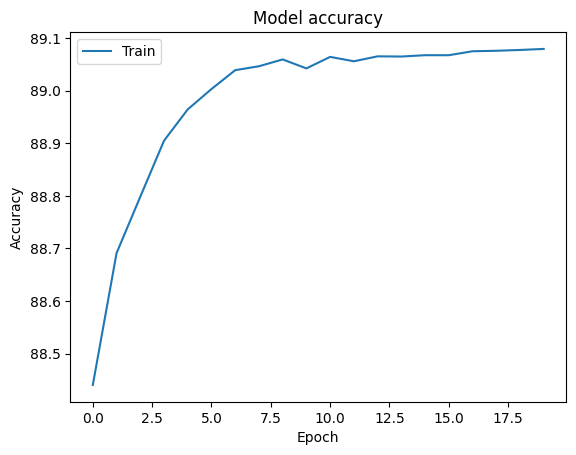

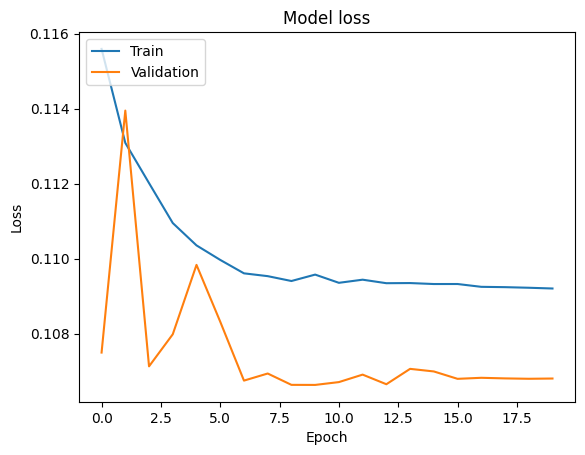

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure()
    plt.plot(history.history["accuracy_percentage"])
    # plt.plot(history.history['loss'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
plot_training_history(history)


In [ ]:
def preprocess_audio(spectrogram):
    print(spectrogram.shape) # Add this line
    # Apply log amplitude compression
    log_spectrogram = np.log10(1 + 10000 * np.abs(spectrogram) ** 2)
    print(log_spectrogram.shape) # Add this line
    # Scale the values between 0 and 1
    scaler = MinMaxScaler()
    scaled_spectrogram = scaler.fit_transform(log_spectrogram)
    print(scaled_spectrogram.shape) # Add this line
    # Add a channel dimension
    X = np.expand_dims(scaled_spectrogram, axis=-1)
    return X, scaler


In [ ]:
def test_generator_wrapper(fg_folder, bg_folder, template_event_parameters, seed, batch_size):
    generator = data_generator(fg_folder, bg_folder, template_event_parameters, seed=seed, batch_size=batch_size)
    while True:
        X_batch = []
        y_batch = []
        mixture_audio_list = []
        stem_audio_list_list = []
        scaler_list = []
        for i in range(batch_size):
            X, y, mixture_audio, stem_audio_list = next(generator)
            print(f"X.shape: {X.shape}, y.shape: {y.shape}, mixture_audio.shape: {mixture_audio.shape}, stem_audio_list: {len(stem_audio_list)}") # Add this line
            mixture_spectrogram, stem_spectrograms = generate_spectrograms(mixture_audio, stem_audio_list)
            X, scaler = preprocess_audio(mixture_spectrogram)
            y = [preprocess_audio(stem_spectrogram)[0] for stem_spectrogram in stem_spectrograms]
            X_batch.append(X)
            y_batch.append(y)
            mixture_audio_list.append(mixture_audio)
            stem_audio_list_list.append(stem_audio_list)
            scaler_list.append(scaler)
        yield np.array(X_batch), np.array(y_batch), mixture_audio_list, stem_audio_list_list, scaler_list


In [ ]:
def display_predictions(model, data_generator, num_samples=1):
    test_generator = data_generator(fg_folder, bg_folder, template_event_parameters, seed=100, batch_size=1)
    for i in range(num_samples):
        # Get the next sample from the data generator
        X_test, y_test, mixture_audio_list, stem_audio_list_list, scaler_list = next(test_generator)
        
        # Predict the separated sources
        y_pred = model.predict(X_test)
        
        # Postprocess the audio and convert it to audio signals
        ground_truth_sources = []
        pred_sources = []
        ground_truth_spectrograms = []
        pred_spectrograms = []
        for i in range(len(y_pred)):
            pred_spectrogram = postprocess_audio_2(y_pred[i], scaler_list[i])
            ground_truth_spectrogram = postprocess_audio_2(y_test[i], scaler_list[i])
            
            pred_sources.append(spectrogram_to_audio(pred_spectrogram))
            ground_truth_sources.append(spectrogram_to_audio(ground_truth_spectrogram))
            pred_spectrograms.append(pred_spectrogram)
            ground_truth_spectrograms.append(ground_truth_spectrogram)

        # Plot the original audio, ground truth, and predicted sources
        plt.figure(figsize=(20, 10))
        plt.subplot(3, 1, 1)
        plt.plot(mixture_audio_list[0])
        plt.title("Original Audio")
        plt.subplot(3, 1, 2)
        plt.plot(stem_audio_list_list[0][0])
        plt.title("Ground Truth")
        plt.subplot(3, 1, 3)
        plt.plot(pred_sources[0])
        plt.title("Predicted Source")
        plt.show()

        # Plot the original and predicted spectrograms
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 1, 1)
        plt.imshow(np.log10(ground_truth_spectrograms[0]), cmap='viridis', aspect='auto')
        plt.title("Original Spectrogram")
        plt.subplot(2, 1, 2)
        plt.imshow(np.log10(pred_spectrograms[0]), cmap='viridis', aspect='auto')
        plt.title("Predicted Spectrogram")
        plt.show()


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('my_first_model\my_basic_Unet_model.h5')

display_predictions(model, test_generator_wrapper, num_samples=1)


NameError: name 'data_generator' is not defined

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from tensorflow.keras.models import load_model

def postprocess_audio_2(preprocessed_audio, scaler):
    preprocessed_audio = preprocessed_audio.reshape(preprocessed_audio.shape[0], -1)
    audio = np.zeros_like(preprocessed_audio)
    
    for i in range(preprocessed_audio.shape[1]):
        audio[:, i] = scaler.inverse_transform(preprocessed_audio[:, i].reshape(-1, 1)).flatten()
    
    audio = audio.reshape(preprocessed_audio.shape)
    return audio




# Load the model (if not loaded already)
model = load_model('my_first_model\my_basic_Unet_model.h5')

def test_generator_wrapper(fg_folder, bg_folder, template_event_parameters, seed, batch_size=1):
    gen = dataset_generator(fg_folder, bg_folder, template_event_parameters, seed, batch_size=batch_size)
    while True:
        X_batch, y_batch = next(gen)
        mixture_audio_list = []
        stem_audio_list_list = []
        scaler_list = []
        
        for i in range(batch_size):
            mixture_audio, mixture_jam, annotation_list, stem_audio_list = incoherent(fg_folder, bg_folder, template_event_parameters, seed + i)
            mixture_spectrogram, stem_spectrograms = generate_spectrograms(mixture_audio, stem_audio_list)
            
            y = [preprocess_audio(stem_spectrogram)[:2][0] for stem_spectrogram in stem_spectrograms]
            
            mixture_audio_list.append(mixture_audio)
            stem_audio_list_list.append(stem_audio_list)
            scaler_list.append(scaler)
        
        X_batch = np.stack(X_batch, axis=0)
        y_batch = np.stack(y_batch, axis=0)
        
        yield X_batch, y_batch, mixture_audio_list, stem_audio_list_list, scaler_list

# Get the test data
test_generator = test_generator_wrapper(fg_folder, bg_folder, template_event_parameters, seed=100, batch_size=1)
X_test, y_test, mixture_audio_list, stem_audio_list_list, scaler_list = next(test_generator)

# Predict the separated sources
y_pred = model.predict(X_test)

# Process the prediction and ground truth
pred_sources = []
ground_truth_sources = []

for i in range(len(y_pred)):
    pred_spectrogram = postprocess_audio_2(y_pred[i], scaler_list[0])
    ground_truth_spectrogram = postprocess_audio_2(y_test[i], scaler_list[0])
    
    pred_sources.append(spectrogram_to_audio(pred_spectrogram))
    ground_truth_sources.append(spectrogram_to_audio(ground_truth_spectrogram))


# Visualize the spectrograms
for i in range(len(pred_sources)):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
    
    original_spectrogram = np.abs(librosa.stft(ground_truth_sources[i]))
    reconstructed_spectrogram = np.abs(librosa.stft(pred_sources[i]))
    
    axes[0].imshow(original_spectrogram, origin='lower', aspect='auto', cmap='viridis')
    axes[0].set_title(f'Original Source {i + 1} Spectrogram')
    axes[0].set_xlabel('Time (frames)')
    axes[0].set_ylabel('Frequency (bins)')

    axes[1].imshow(reconstructed_spectrogram, origin='lower', aspect='auto', cmap='viridis')
    axes[1].set_title(f'Reconstructed Source {i + 1} Spectrogram')
    axes[1].set_xlabel('Time (frames)')
    axes[1].set_ylabel('Frequency (bins)')
    
    fig.colorbar(img, ax=axes.ravel().tolist(), pad=0.02)
    plt.show()

# Play the original mixture
print("Original Mixture Audio:")
display(Audio(mixture_audio.squeeze(), rate=44100))

# Play the ground truth sources
for i, source_audio in enumerate(ground_truth_sources):
    print(f"Ground Truth Source {i + 1}:")
    display(Audio(source_audio, rate=44100))

# Play the predicted sources
for i, source_audio in enumerate(pred_sources):
    print(f"Predicted Source {i + 1}:")
    display(Audio(source_audio, rate=44100))


1/1 [==============================] - 136s 136s/step


ValueError: non-broadcastable output operand with shape (4,1) doesn't match the broadcast shape (4,517)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Save the model
model.save('unet_model.h5')

# Alternatively, save only the weights
model.save_weights('unet_weights.h5')


In [ ]:
from tensorflow.keras.optimizers import Adam

# Assuming you already have the Unet model defined as 'model'
model.compile(optimizer=Adam(lr=1e-4), loss='mean_squared_error')

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    verbose=1
)


NameError: name 'model' is not defined

In [ ]:

# Train the model
batch_size = 4
epochs = 10
steps_per_epoch = len(dataset) // batch_size

model.fit(
    dataset_generator(dataset),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    batch_size=batch_size,
)

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        mix_magnitude = batch[0].to(device)
        mix_magnitude = torch.squeeze(mix_magnitude)  # Add this line before passing the input to the model
        source_magnitudes = batch[1].to(device)

        optimizer.zero_grad()
        outputs = model(mix_magnitude)
        loss = criterion(outputs, source_magnitudes)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * mix_magnitude.size(0)
    return running_loss / len(dataloader.dataset)



def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            mix_magnitude = batch[0].unsqueeze(1).to(device)
            source_magnitudes = batch[1].to(device)

            outputs = model(mix_magnitude)
            loss = criterion(outputs, source_magnitudes)
            running_loss += loss.item()

    return running_loss / len(dataloader)

In [ ]:
number_of_mixtures = 2
variations_per_mixture = 5

# Replace 'AudioDataset' with 'MixtureDataset' when creating instances of the class
incoherent_dataset = MixtureDataset(
    fg_folder=fg_folder,
    bg_folder=bg_folder,
    template_event_parameters=template_event_parameters,
    seed=seed,
    number_of_mixtures=number_of_mixtures,
    variations_per_mixture=variations_per_mixture,
    mix_func=incoherent
)

coherent_dataset = MixtureDataset(
    fg_folder=fg_folder,
    bg_folder=bg_folder,
    template_event_parameters=template_event_parameters,
    seed=seed,
    number_of_mixtures=number_of_mixtures,
    variations_per_mixture=variations_per_mixture,
    mix_func=coherent
)


batch_size = 1

incoherent_loader = DataLoader(incoherent_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
coherent_loader = DataLoader(coherent_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AudioSeparator().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss = train(model, incoherent_loader, criterion, optimizer, device)
    print(f"Incoherent Train Loss: {train_loss:.4f}")

    train_loss = train(model, coherent_loader, criterion, optimizer, device)
    print(f"Coherent Train Loss: {train_loss:.4f}")

    val_loss = validate(model, incoherent_loader, criterion, device)
    print(f"Incoherent Val Loss: {val_loss:.4f}")

    val_loss = validate(model, coherent_loader, criterion, device)
    print(f"Coherent Val Loss: {val_loss:.4f}")

    print()

Epoch 1/5


RuntimeError: Given groups=1, weight of size [512, 1, 5], expected input[1, 431, 1025] to have 1 channels, but got 431 channels instead

In [ ]:
torch.save(model.state_dict(), 'audio_separator.pth')
